In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.cmb_lensing
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = ['#1A1A1A', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [11]:
# create an Observables object to store information for derivatives
pars = np.array( ['omega_b', 'omega_cdm', '100*theta_s',  'A_s', 'n_s', 'tau_reio', 'N_eff'])
centers = np.array([0.02222,  0.1197,  1.042143,  2.1955e-9, 0.9655, 0.06, 3.046])
left_steps = np.array([0.0008, 0.003,   0.05,   0.1e-9, 0.01, 0.02, 0.02])
right_steps = np.array([0.0008, 0.003,   0.05,   0.1e-9, 0.01, 0.02, 0.02])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-left_steps,
                  right=centers+right_steps)

# generate a template CLASS python wrapper configuration
classy_template =  {'output': 'tCl pCl lCl mPk',
                    'l_max_scalars': 5000,
                    'lensing': 'yes',
#                     'reionization_optical_depth_tol': 1e-07,
#                     'tol_background_integration': 1e-8,
#                     'tol_perturb_integration': 1e-8,
#                     'tol_thermo_integration': 1e-8,
#                     'perturb_sampling_stepsize':0.01,
#                     'k_max_tau0_over_l_max' : 6,
#                     'P_k_max_1/Mpc':3.0
                  }
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

In [12]:
# generate the fiducial cosmology
obs.compute_cosmo(key='fiducial',
                  classy_dict=fishchips.util.neutrino_dict(classy_template))

In [13]:
# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_left',
                      classy_dict=fishchips.util.neutrino_dict(classy_left))
    obs.compute_cosmo(key=par + '_right',
                      classy_dict=fishchips.util.neutrino_dict(classy_right))

In [14]:
obs.cosmos

{'fiducial': <classy.Class at 0x558865c12fe8>,
 'omega_b_left': <classy.Class at 0x558865ba9068>,
 'omega_b_right': <classy.Class at 0x558865c311a8>,
 'omega_cdm_left': <classy.Class at 0x558865ef3ea8>,
 'omega_cdm_right': <classy.Class at 0x558867fae898>,
 '100*theta_s_left': <classy.Class at 0x558868021c38>,
 '100*theta_s_right': <classy.Class at 0x55886804d7f8>,
 'A_s_left': <classy.Class at 0x55886e1d4cb8>,
 'A_s_right': <classy.Class at 0x5588721ede18>,
 'n_s_left': <classy.Class at 0x5588722611c8>,
 'n_s_right': <classy.Class at 0x5588743de338>,
 'tau_reio_left': <classy.Class at 0x5588744069d8>,
 'tau_reio_right': <classy.Class at 0x55887a5b22d8>,
 'N_eff_left': <classy.Class at 0x55887c65e3a8>,
 'N_eff_right': <classy.Class at 0x55887c6d3088>}

generating new axis
['$\\mathrm{omega\\_b}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{100*theta\\_s}$', '$\\mathrm{A\\_s}$', '$\\mathrm{n\\_s}$', '$\\mathrm{tau\\_reio}$', '$\\mathrm{N\\_eff}$']


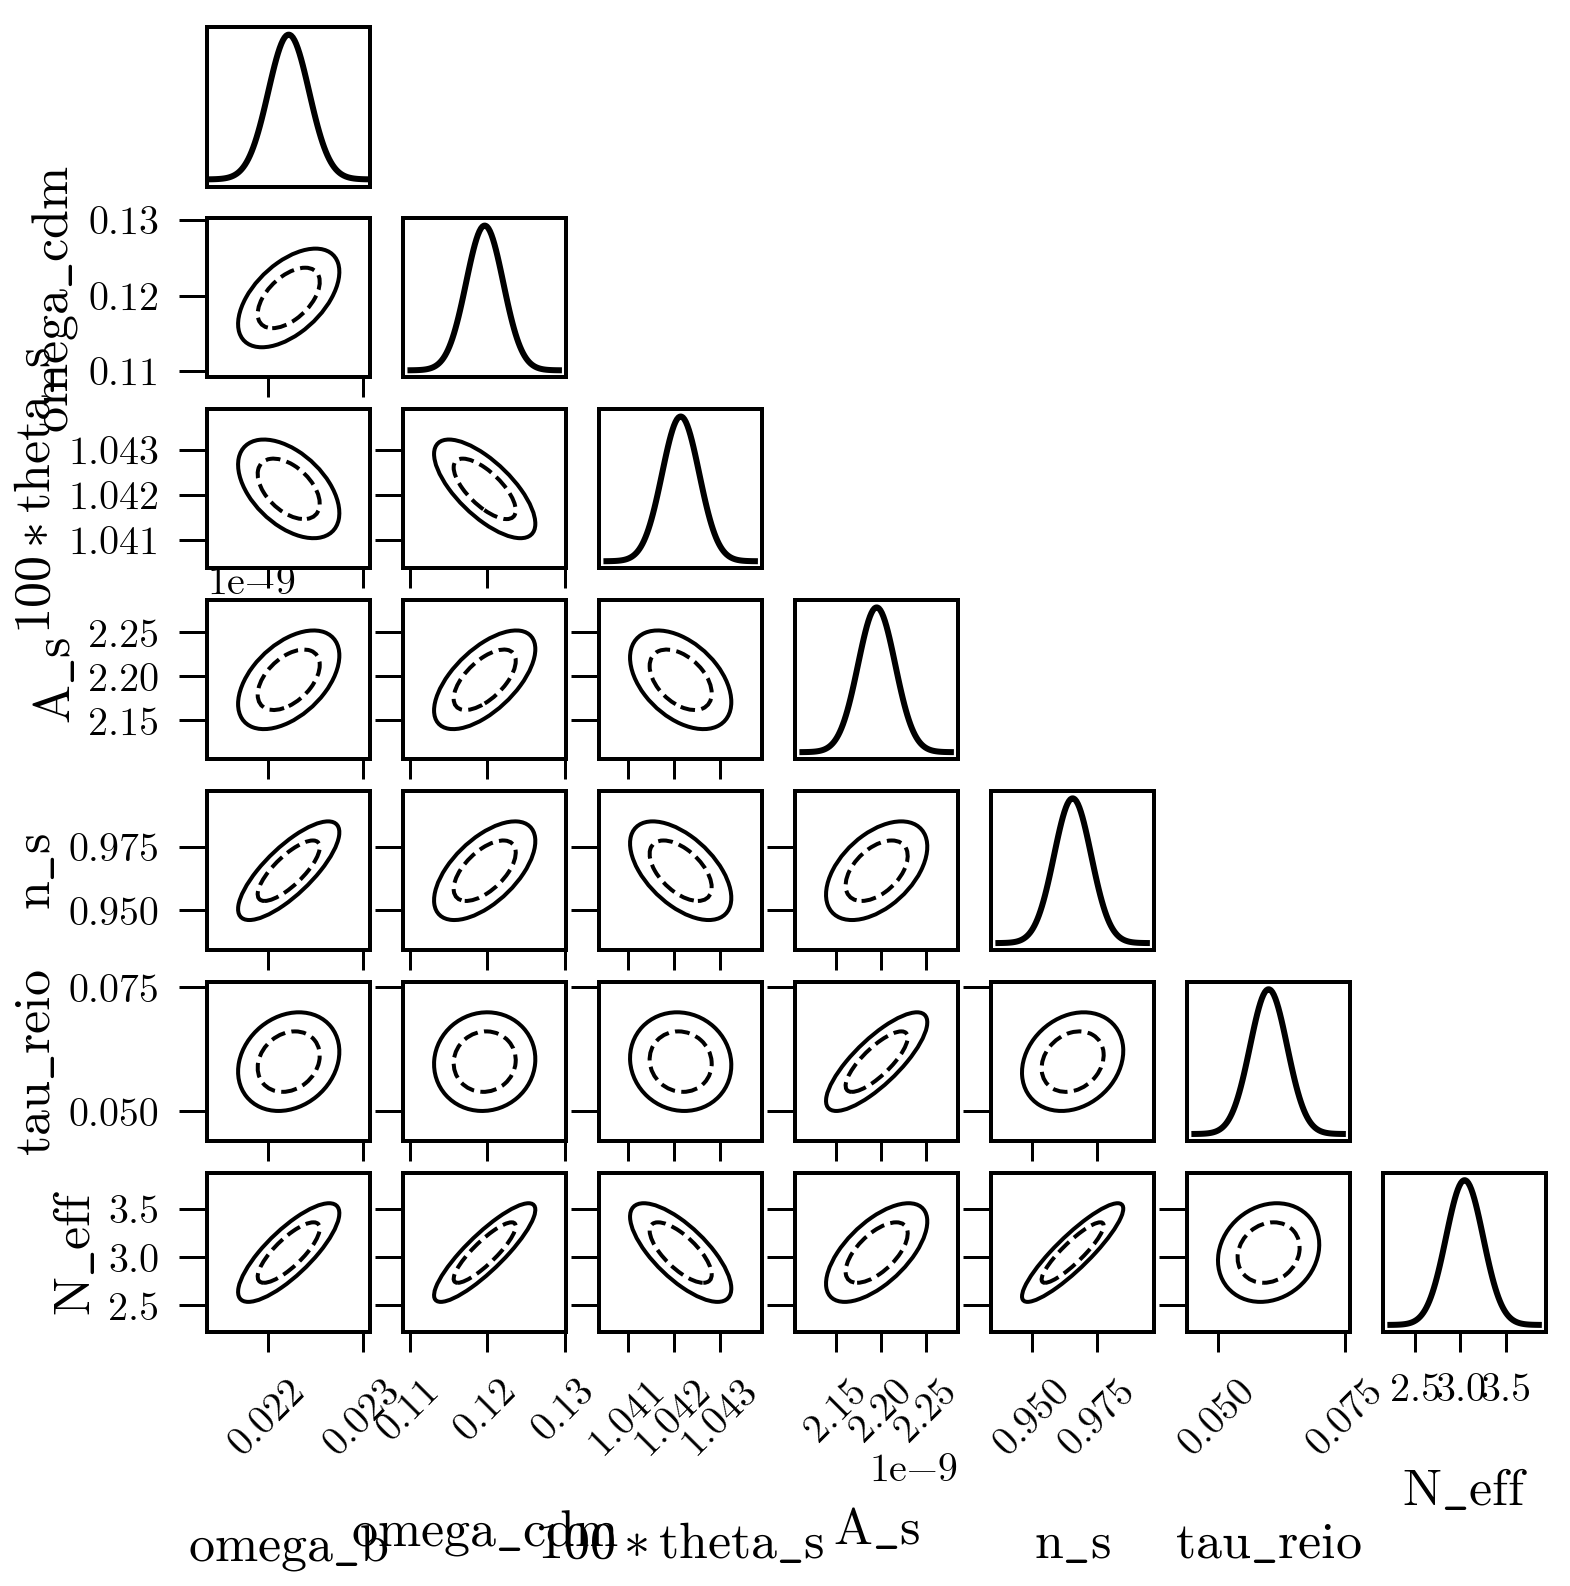

In [15]:
example_Planck = CMB_Primary(
    theta_fwhm=[7.], sigma_T=[33.], sigma_P=[56.],
    f_sky=0.65, l_min=2, l_max=2500)
fisher = example_Planck.get_fisher(obs)
cov = np.linalg.inv(fisher)
fishchips.util.plot_triangle(obs, cov);